In [151]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.discrete.discrete_model import Logit
import spacy

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge,ElasticNet,LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from category_encoders import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix, balanced_accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


import sklearn
sklearn.set_config(display='diagram')



import requests

### Webscraping reddit comments to a df

Majority of the code in the cell below is commented out to prevent the user from creating another dataframe. The csv file attached to this folder has comments from April 27,2021 and before. If the user wants to create a modern dataframe, they can remove the commented out sections below

In [4]:
# import time
base_url = 'https://api.pushshift.io'
submission_endpt = '/reddit/submission/search' #main posts in the subreddit
comment_endpt = '/reddit/comment/search' #comments on the posts

#create a function that reads a comment from reddit and creates a dataframe
def reddit_comments(base_url,endpt_url,params):
    '''This function takes a base url as a string, a endpoint as a string (can be comments or titles) 
    and a dictionary as parameters to return a dataframe of 5,000 comments from a subreddit 
    specified.'''
    #intialize empty df 
    df_final = pd.DataFrame({'subreddit':[],'body':[]})
    for i in range(50):
        #for each iteration, assign a variable posts to the data
        res = requests.get(base_url+endpt_url,params)
        posts = res.json()['data']
        #update the params dictionary key 'before' with the latest date from our posts
        params['before'] = posts[-1]['created_utc']
        #create a df from our posts 
        df = pd.DataFrame(posts)
        df_temp = df[['subreddit','body']]
        #append the df to a larger dataframe 
        df_temp.loc[(df_temp['body'] != '[removed]'),:]
        df_final = pd.concat([df_final,df_temp])
        # set a delay and print out which step we're at
        time.sleep(5)
        print(i)
    return df_final

#test to see if the function workds
# #test = reddit_comments(base_url,comment_endpt,params)


#set parameters and create a machine learning df
params = {
    'subreddit':'MachineLearning',
    'size':100,
    'before':None}
# ml_df = reddit_comments(base_url,comment_endpt,params)


#set parameters and create a artificial intelligence df
params = {
    'subreddit':'artificial',
    'size':100,
    'before':None }
# ai_df = reddit_comments(base_url,comment_endpt,params)

#export df to csv file
#ai_df.to_csv('ai_df.csv',index=False)
#ml_df.to_csv('ml_df.csv',index=False)

## Inspect ml and ai dataframe

In [5]:
ml_df = pd.read_csv('./ml_df.csv')

ai_df = pd.read_csv('./ai_df.csv')


(ml_df['body']=='[removed]').sum() #20

(ml_df['body']=='[deleted]').sum() #62

(ai_df['body']=='[removed]').sum() #36

(ai_df['body']=='[deleted]').sum() #75

In [12]:
ai_df.head(2)

,subreddit,body
0,artificial,I have an understanding of basic calculus and ...
1,artificial,I don't know how deep in you are in calculus b...


### Add the comment length and word count to each df

In [13]:
#comment length and word count for ml df
length = []
for i in range(ml_df.shape[0]):
    length.append(len(ml_df['body'][i]))
ml_df['comment_length'] = length

words = []
for i in range(ml_df.shape[0]):
    words.append(len(ml_df['body'][i].split(' ')))
ml_df['comment_word_count'] = words


#comment length and word count for ai df
length = []
for i in range(ai_df.shape[0]):
    length.append(len(ai_df['body'][i]))
ai_df['comment_length'] = length

words = []
for i in range(ai_df.shape[0]):
    words.append(len(ai_df['body'][i].split(' ')))
ai_df['comment_word_count'] = words

In [16]:
ml_df.head()

,subreddit,body,comment_length,comment_word_count
0,MachineLearning,"Bottom line is, not everyone can do what IT an...",520,94
1,MachineLearning,You are not alone with this. Because of the ea...,2526,411
2,MachineLearning,This sounds familiar to me. Feeling like an im...,627,114
3,MachineLearning,OP is dumb...jeez.,18,3
4,MachineLearning,This is getting so old. Please verify my skill...,127,25


### Inspect & EDA

In [17]:
ml_df['comment_word_count'].sort_values()[-5:]# 689,695,724,940,942
ml_df['comment_word_count'].mean() #54

ai_df['comment_word_count'].sort_values()[-5:]# 1298,1300,1311,1335,1350
ai_df['comment_word_count'].mean() #50

49.0864

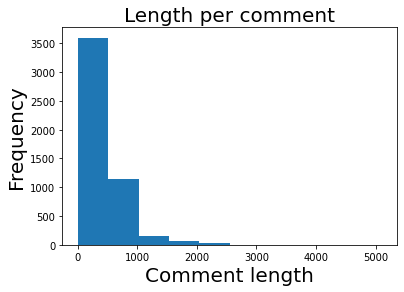

In [135]:
plt.hist(ml_df['comment_length'],bins=10);
plt.xlabel('Comment length', size=20);
plt.ylabel('Frequency', size=20);
plt.title('Length per comment',size=20);

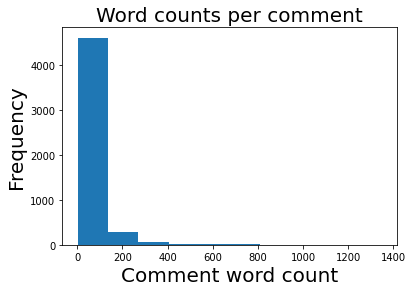

In [134]:
plt.hist(ml_df['comment_word_count'],bins=10);
plt.xlabel('Comment word count', size=20);
plt.ylabel('Frequency', size=20);
plt.title('Word counts per comment',size=20);
#try to remove outliers and do 200+ plotly can help

Above we see that both df's have the same mean word count, they're very similar but ml has a higher frequency of comment length. Also ai has more comments with larger word counts. Unsure if this will be a good predictor to subreddit, but it tells us more about the activity going on in each space

Some words may apprear more requently than others that have nothing to do with either subreddit. To account for this a new_comment section is being created to remove both of these words

In [19]:
# Replacing unwanted word 
def remove_unwanted(comment):
    '''Thif function takes a comment and checks to see if any of the words in the unwanted
    list are in that comment. If so its repalced with irrlevant_. The goal of this is to
    remove repetative words.b'''
    new_comment = ''
    #unwanted = ['https','www','reddit','com','related','questions']
    unwanted = ['https','www','reddit','com','related','questions','https www','reddit com',
           'reddit.com','www.reddit.com','www reddit com','https www reddit']
    for word in comment.split(' '):
        if word in unwanted:
            new_comment += 'irrelevant_ '
        else:
            new_comment += word + ' '
    return new_comment

In [20]:
#create df with both ai and ml subreddits
df = pd.concat([ml_df,ai_df]).reset_index(drop=True)
df.shape #(10000, 4)

#assign target for binary classification
df['target'] = df['subreddit'].replace('MachineLearning',1).replace('artificial',0)
df.shape #(10000, 5)

#apply remove_unwanted to comments in df
df['new_comments'] = df['body'].apply(lambda comment: remove_unwanted(comment))
df.shape #(10000, 6)
df.head(3)

,subreddit,body,comment_length,comment_word_count,target,new_comments
0,MachineLearning,"Bottom line is, not everyone can do what IT an...",520,94,1,"Bottom line is, not everyone can do what IT an..."
1,MachineLearning,You are not alone with this. Because of the ea...,2526,411,1,You are not alone with this. Because of the ea...
2,MachineLearning,This sounds familiar to me. Feeling like an im...,627,114,1,This sounds familiar to me. Feeling like an im...


<AxesSubplot:>

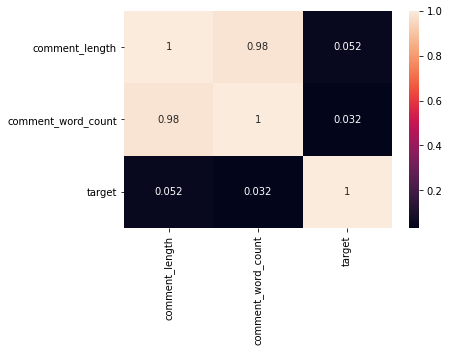

In [140]:
sns.heatmap(df.corr(),annot=True)

The heatmap above shows that the comment length and word counts aren't highly correlated to our target, its best we take this out

### Assign X y and perform Train Test Split

In [22]:
X = df[['body','comment_length','comment_word_count']]#new_comments was not useful
y = df['target']

X_train,X_test,y_train,y_test = train_test_split(X,y)

X_train.shape #(7500, 3)
X_test.shape #(2500, 3)
y_train.shape # (7500,)
y_test.shape # (2500,)

## Pass through Logistic Regression pipe

In [146]:
trans_col = make_column_transformer(
                                (CountVectorizer(stop_words='english'),'body'),
                                remainder='passthrough')
pipe_lr = make_pipeline(
                        trans_col,
                        StandardScaler(with_mean=False),
                        LogisticRegression())

pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_train,y_train) #.97
pipe_lr.score(X_test,y_test) #.68
balanced_accuracy_score(y_test,pipe_lr.predict(X_test))#0.68

#len(pipe_lr['logisticregression'].coef_[0])#18,638
#np.where(pipe_lr['logisticregression'].coef_[0] > 0.5,1,0).sum() #954
#np.where(pipe_lr['logisticregression'].coef_[0] > 0.5,1,0).sum() #20

/Users/anthonyreid/opt/anaconda3/envs/numpy/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6811892912579411

Above we have a 68 score on accuracy and balanced accuracy on the test set. Better than our null model of 50% but we can try to imporve on this. An interesting thing to note is that the countvectorizer created 18,000 + features for words but less than 1,000 had a coefficient higher than 0.1. Only 20 features had a coefficient higher than 0.5. Those 20 words that were highly correlated are listed in a df below!

In [147]:
#go into pipe and then trans col and then get coef and featur names 
coefs = pipe_lr['logisticregression'].coef_
features = trans_col.get_feature_names()
coef_df = pd.DataFrame({'coefs': coefs[0], 'word': features})
coef_df.nlargest(20, 'coefs')

,coefs,word
17004,0.872088,countvectorizer__title
4696,0.799195,countvectorizer__criteria
11075,0.741262,countvectorizer__ml
12637,0.733772,countvectorizer__phd
13689,0.724411,countvectorizer__questions
17321,0.715406,countvectorizer__true
5410,0.681448,countvectorizer__different
11085,0.642384,countvectorizer__mlquestions
4954,0.611168,countvectorizer__day
13772,0.602949,countvectorizer__random


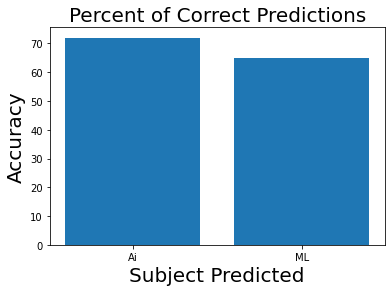

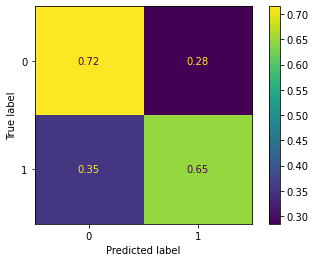

In [28]:
plot_confusion_matrix(pipe_lr,X_test,y_test,normalize='true')


Our model is predicting 65% of the ml subreddits correct and 72% of the ai subreddits correct. We can check other metrics for performance, but keeping it to balanced accuracy and accuracy are enoguh for this model because there is no penalty for type 1 or 2 errors

## Pass lemmatization to a few estimators

In [30]:
#Create lemmatization formula to pass to other 
nlp = spacy.load('en_core_web_sm')
def lemmatized(sentence):
    doc = nlp(sentence)
    return [token.lemma_ for token in doc]

## Logistic Regression through GridSearch

In [46]:
trans_col = make_column_transformer(
                                (CountVectorizer(tokenizer=lemmatized,
                                                stop_words='english',
                                                max_features=10_000),
                                                 'body'),
                                remainder='passthrough')
pipe_lr2 = make_pipeline(
                        trans_col,
                        StandardScaler(with_mean=False),
                        LogisticRegression(n_jobs = -1))
params_lr = {
        #'trans_col__countvectorizer__max_features': [6000,10_000, 13_000],
         #'countvectorizer__stop_words':['english',None],     
          #'countvectorizer__tokenizer':[lemmatized,None],
          'logisticregression__C':[0.5, 0.75, 1]
          }

gs_lr = GridSearchCV(pipe_lr2, params_lr, n_jobs = -1)
gs_lr.fit(X_train,y_train)
gs_lr.score(X_train,y_train)#0.97
gs_lr.score(X_test,y_test)  #0.71

In [51]:
pd.DataFrame(gs_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,131.529703,0.258405,31.383164,0.433072,0.5,{'logisticregression__C': 0.5},0.718000,0.738,0.704667,0.732000,0.711333,0.720800,0.012482,1
1,129.567851,2.469366,30.908482,0.720000,0.75,{'logisticregression__C': 0.75},0.716667,0.734,0.701333,0.725333,0.709333,0.717333,0.011508,2
2,127.794846,0.496050,29.857006,0.359817,1,{'logisticregression__C': 1},0.710667,0.732,0.699333,0.722667,0.707333,0.714400,0.011567,3


The grid search revealed that an upgrade to our countvectorizer and logistic regression improved the score. As we lemmatize our words (ranking by popularity of the root words) and decreasing our C (the inverse of alpha) to 0.5, we improve our score to 72%

## Decision Tree Classifier 

In [159]:
#create column transformer to pass to pipe
trans_col_dtree = make_column_transformer(
                                    (TfidfVectorizer(stop_words = 'english'),
                                    'body'))
#create pipe 
pipe_dtree = make_pipeline(trans_col_dtree,
                          StandardScaler(with_mean=False),
                          DecisionTreeClassifier(criterion='entropy',
                                                max_depth=4))
#fit and score
pipe_dtree.fit(X_train,y_train)
pipe_dtree.score(X_train,y_train) # 983
pipe_dtree.score(X_test,y_test) #0.68 #with 10,000 max depth



0.616

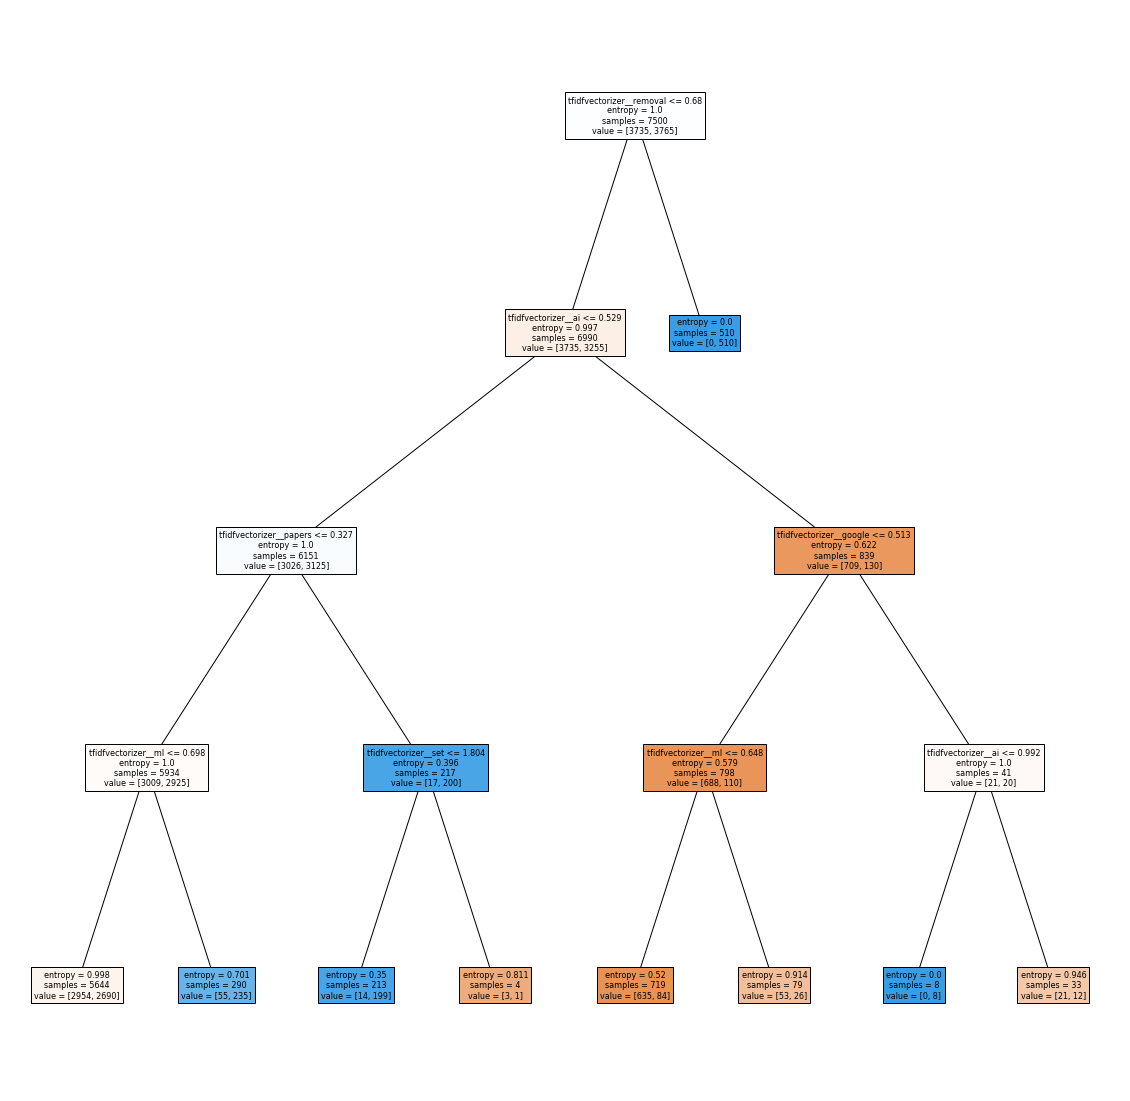

In [161]:
#Plot and interpret
plt.figure(figsize=(20,20));
plot_tree(pipe_dtree['decisiontreeclassifier'], feature_names = trans_col_dtree.get_feature_names(), filled=True);

My original decision tree with the best score had max features up to 10,000 but this image above has max depth of 4 to show which features the decision tree is splitting on. The top 6 features the decision tree is splitting on it ai, papers, google, and ml with an entropy grading criteria. The best performing tree had an accuracy score of 68% this is performing less than the logistic regression. 

## Random forest Classifier

In [165]:
#reassign xtrain to have only text
X_train1 = X_train['body']
pipe_rf = make_pipeline(TfidfVectorizer(stop_words='english'),
                       StandardScaler(with_mean=False),
                       RandomForestClassifier(n_estimators=500))

#fit and score
pipe_rf.fit(X_train1,y_train)
pipe_rf.score(X_train1,y_train)#.98 w tfdif

X_test1 = X_test['body']
pipe_rf.score(X_test1,y_test) #.75 w. cvect
#pipe_rf.score(X_test1,y_test) #.745 w. tfdif

0.748

The random forest classifier is an ensembling method that takes many decision trees and chooses the most popular output for each step. This is a good method because as we saw with the single decision tree, our a score was 68% but with 500 trees our score increased to 75%

## Multinomial NaiveBayes

In [166]:
trans_col_nb = make_column_transformer(
                                (CountVectorizer(),'body'),
                                remainder='passthrough')
pipe_nb = make_pipeline(
                        trans_col_nb,
                        StandardScaler(with_mean=False),
                        MultinomialNB())

pipe_nb.fit(X_train,y_train)
pipe_nb.score(X_train,y_train) #.90
pipe_nb.score(X_test,y_test) #.71
balanced_accuracy_score(y_test,pipe_nb.predict(X_test))

0.7133939287257365

Naive bayes is a great classifier that uses conditional probabilities of features and targets to make predictions about the target. There is less matrix algebra and other difficult math involved in this estimator, but the results are still very close to some of the earlier regressors. The final score was 71%

## Nearest neighbor classifier 

In [127]:
trans_col_knn = make_column_transformer(
                                (CountVectorizer(),'body'),
                                remainder='passthrough')

pipe_knn = make_pipeline(trans_col_knn,
                        KNeighborsClassifier(n_jobs=-1)
                        )
pipe_knn.fit(X_train,y_train)
pipe_knn.score(X_train,y_train)#0.727
pipe_knn.score(X_test,y_test) #0.5776


0.5776

The nearest neighbor classifier was the worst performing estimator at 57% accuracy and was greater than the null by a relatively small margin.  

## Ensemble with best estimators (Logistic, RF, Naive Baye)

In [167]:
pipe_ensem = make_pipeline(CountVectorizer(stop_words='english'),
                           VotingClassifier([('rf', RandomForestClassifier()),
                                             ('lr', LogisticRegression(C=0.5)),
                                             ('nb', MultinomialNB())
                                            ]
                                            ))
params_ensem = {
    #'votingclassifer__voting': ['hard', 'soft'],
    #'votingclassifer__weights': [[1, 0, 0],[0, 1, 0], [0, 0, 1],[.3, .3, .3], [.4, .2, .4]],
    #'countvectorizer__stop_words':['english',None],
    'countvectorizer__ngram_range':[(2,3),(1,2)]
}
                           
gs_ensem = GridSearchCV(pipe_ensem, params_ensem, n_jobs=-1)
gs_ensem.fit(X_train1,y_train)
gs_ensem.score(X_train1,y_train)#0.977
gs_ensem.score(X_test1,y_test)#0.77

0.7788

In [125]:
gs_ensem.best_estimator_

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('votingclassifier',
                 VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                                              ('lr', LogisticRegression()),
                                              ('nb', MultinomialNB())]))])

In [210]:

gs_ensem.predict(['the use and development of computer systems that are able to learn and adapt without following explicit instructions, by using algorithms and statistical models to analyze and draw inferences from patterns in data.']) #0
gs_ensem.predict(['the theory and development of computer systems able to perform tasks that normally require human intelligence, such as visual perception, speech recognition, decision-making, and translation between languages.']) #0
gs_ensem.predict(['ai ai ai ai']) #0
gs_ensem.predict(['ml ml ml ml']) #1
gs_ensem.predict([' title criteria phd true']) #1
gs_ensem.predict(['robots start liked source humans'])#0

gs_ensem.predict(['I will probably never be in a position to use this personally, but kudos for the effort and putting this out there! More efficient models is a good and worthwhile goal.']) #1
gs_ensem.predict(['One way it has changed the industry is that there are so many people on sites like fiverr that advertise human translation but then just use google translate. Probably the majority.'])#0
gs_ensem.predict(['please predict machine learning'])#0

array([0])

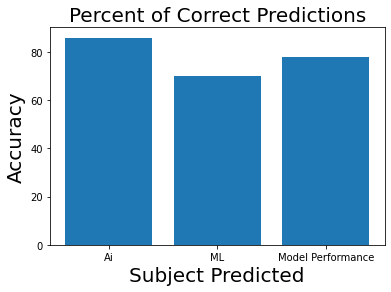

In [208]:
plt.bar(['Ai','ML','Model Performance'],[86,70,78]);
plt.xlabel('Subject Predicted',size =20);
plt.ylabel('Accuracy',size = 20);
plt.title('Percent of Correct Predictions',size = 20);

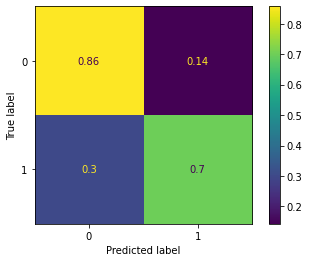

In [207]:
plot_confusion_matrix(gs_ensem,X_test1, y_test, normalize='true')

In [187]:
pd.DataFrame(gs_ensem.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,97.538088,2.781272,1.356857,0.216082,"(2, 3)","{'countvectorizer__ngram_range': (2, 3)}",0.641333,0.640667,0.646667,0.654667,0.657333,0.648133,0.006804,2
1,65.876507,27.733949,0.496601,0.182906,"(1, 2)","{'countvectorizer__ngram_range': (1, 2)}",0.755333,0.765333,0.754000,0.759333,0.766667,0.760133,0.005119,1
